# An IJulia Preview

This notebook is a preview demo of **IJulia**: a [Julia-language](http://julialang.org/) backend combined with the [Jupyter](http://jupyter.org/) interactive environment.   This combination allows you to interact with the Julia language using Jupyter's powerful [graphical notebook](http://ipython.org/notebook.html), which combines code, formatted text, math, and multimedia in a single document.

* Note: this is a *preview*, because it relies on pre-release bleeding-edge versions of Julia, IPython, and several Julia packages, as explained on the [IJulia github page](https://github.com/JuliaLang/IJulia.jl), and functionality is evolving rapidly.  We hope to have a more polished release soon.

* Note 2: this is a slightly modified version of the [original IJulia preview](https://nbviewer.jupyter.org/url/jdj.mit.edu/~stevenj/IJulia%20Preview.ipynb) on the nbconvert website.

## Basic Julia interaction

Basic mathematical expressions work like you expect:

In [1]:
1 + sin(3)

1.1411200080598671

You can define variables, write loops, and execute arbitrary multiline code blocks.  Here is an example of an alternating harmonic series $\sum_{n=1}^\infty \frac{(-1)^n}{n}$ from a [Julia tutorial by Homer Reid](http://homerreid.ath.cx/teaching/18.330/JuliaProgramming.shtml#SimplePrograms):

In [2]:
s = 0.0
for n = 1:2:10000
    s += 1/n - 1/(n+1)
end
s # an expression on the last line (if it doesn't end with ";") is printed as "Out"

0.6930971830599458

Previous outputs can be referred to via `Out[`*n*`]`, following the IPython, for example `Out[2]` for the result above.  You can also use the shorthand `_2`, or `_` for the previous result, as in IPython.  Like in Matlab, `ans` can also be used to refer to the previous result, *even if it was not printed* (when the command ended with `;`).

For example, the harmonic series above should be converging (slowly) to $\ln 2$, and we can check this:

In [3]:
Out[2] - log(2)

-4.9997499999454575e-5

Like Matlab or Scipy + Numpy, Julia has lots of mathematical functions and linear algebra built in.  For example, we can define a $500\times500$ random matrix $R$ and form the positive-definite matrix $R^* R$:

In [4]:
R = rand(500,500)
R' * R

500x500 Float64 Array:
 162.603  127.476  125.076  118.914  …  121.913  119.346  123.416  118.659
 127.476  173.211  132.191  125.419     131.765  126.816  131.182  126.373
 125.076  132.191  165.643  122.073     123.358  119.285  127.365  127.132
 118.914  125.419  122.073  161.962     124.197  116.947  125.176  119.248
 119.912  127.888  125.779  119.243     124.572  120.879  124.785  123.494
 113.774  118.241  121.404  118.418  …  121.256  118.652  120.242  117.505
 125.258  128.183  125.683  123.607     122.044  120.701  127.675  123.064
 123.856  128.797  127.62   126.731     125.854  121.413  130.059  129.455
 119.448  123.88   122.982  117.524     119.345  119.598  121.751  120.35 
 121.084  132.255  125.685  126.087     125.765  122.052  134.187  124.131
   ⋮                                 ⋱                                    
 122.913  126.649  124.402  122.839  …  128.841  119.598  131.985  119.851
 119.279  120.223  119.79   118.196     121.333  116.689  121.644  117.713
 1

(Notice that, by default, only a portion of a large matrix is shown.  You didn't really want to read $500^2 = 250,000$ numbers, did you?)

Standard output from Julia is also captured and sent to the IJulia notebook as you'd expect:

In [5]:
println("Hello world!\n")
println(STDERR, "Börk börk börk, some unicode output on stderr...\n")

Hello world!



Börk börk börk, some unicode output on stderr...



IJulia even captures output from external C libraries (and notice how easy it is using Julia's `ccall` intrinsic):

In [5]:
ccall(:printf, Cint, (Ptr{Uint8},), "Hello from C!!\n");

We can define functions, of course, and use them in later input cells:

In [6]:
f(x) = x + 1

# methods for generic function f
f(x) at In[6]:1

In [7]:
println(f(3))
f([1,1,2,3,5,8])

Hello from C!!
4

6-element Int64 Array:
 2
 2
 3
 4
 6
 9

Notice that the input above both printed an scalar to `STDOUT` and also returned a vector, the latter using Julia's ability to write polymorphic functions and built-in array operations.

On the other hand adding a string to a number is not defined (there is no `+` method defined for those types, although we could easily add one), and attempting to do so will throw an exception:

In [8]:
f("Hello?")

LoadError: no method +(ASCIIString,Int64)
at In[8]:1

## Julia–Python interoperability: SciPy and Matplotlib

Julia can easily and transparently call external Python code using a package called [PyCall](https://github.com/stevengj/PyCall.jl), and to illustrate that capability we will show some examples calling [SciPy](http://www.scipy.org/) and [Matplotlib](http://matplotlib.org/) from Julia.

For example, we can use the [Newton solver in scipy.optimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html) to solve a transcendental equation $\cos(x) - x = 0$ given a *Julia* function:

In [9]:
using PyCall
@pyimport scipy.optimize as so
so.newton(x -> cos(x) - x, 1)

0.7390851332151607

We can use the same `@pyimport` syntax to import Matplotlib (specifically, the `matplotlib.pyplot` module), but to integrate Matplotlib's graphics with the IJulia display requires a little more work.  To simplify this, we've created a [PyPlot module](https://github.com/stevengj/PyPlot.jl) for Julia:

PyObject <matplotlib.text.Text object at 0x1190c7b50>

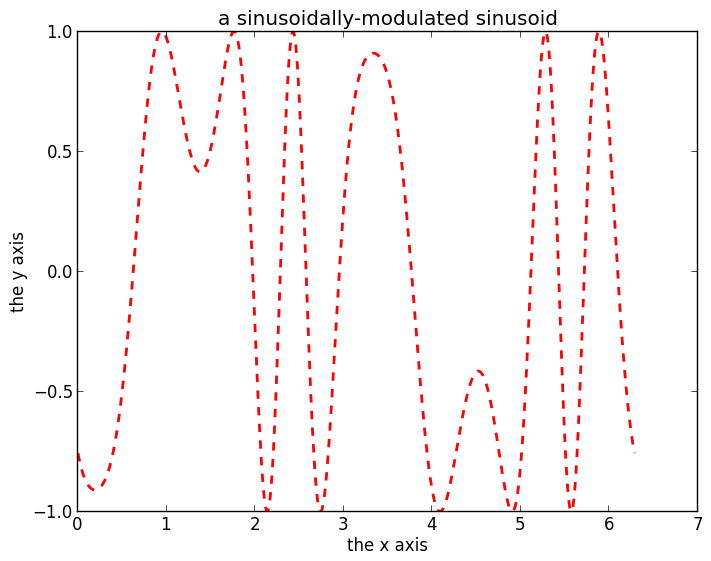

In [10]:
using PyPlot
x = linspace(0,2*pi,1000)
y = sin(3*x + 4*cos(2*x))
plot(x, y, color="red", linewidth=2.0, linestyle="--")
ylabel("the y axis")
xlabel("the x axis")
title("a sinusoidally-modulated sinusoid")

Notice that, by default, the plots are displayed inline (just as for the `%pylab inline` "magic" in IPython).  This kind of multimedia display can be enabled for *any* Julia object, as explained in the next section.

## Multimedia display in IJulia

Like most programming languages, Julia has a built-in `print(x)` function for outputting an object `x` as text, and you can override the resulting text representation of a user-defined type by overloading Julia's `show` function.  The next version of Julia, however, will extend this to a more general mechanism to display **arbitrary multimedia representations** of objects, as defined by standard [MIME types](https://en.wikipedia.org/wiki/Internet_media_type).   More specifically, the Julia [multimedia I/O API](http://docs.julialang.org/en/latest/stdlib/base/#multimedia-i-o) provides:

* A `display(x)` function requests the richest available multimedia display of a Julia object x (with a `text/plain` fallback).
* Overloading `writemime` allows one to indicate arbitrary multimedia representations (keyed by standard MIME types) of user-defined types.
* Multimedia-capable display backends may be registered by subclassing a generic `Display` type.  IJulia provides one such backend which, thanks to the IPython notebook, is capable of displaying HTML, LaTeX, SVG, PNG, and JPEG media formats.

The last two points are critical, because they separate **multimedia export** (which is defined by functions associated with the originating Julia data) from **multimedia display** (defined by backends which know nothing about the source of the data).

Precisely these mechanism were used to create the inline PyPlot plots above.   To start with, the simplest thing is to provide the MIME type of the data when you call `display`, which allows you to pass "raw" data in the corresponding format:

In [11]:
display("text/html", """Hello <b>world</b> in <font color="red">HTML</font>!""")

Hello world in HTML !

However, it will be more common to attach this information to types, so that they display correctly automatically.  For example, let's define a simple `HTML` type in Julia that contains a string and automatically displays as HTML (given an HTML-capable backend such as IJulia):

In [12]:
type HTML
   s::String
end
import Base.writemime
writemime(io::IO, ::@MIME("text/html"), x::HTML) = print(io, x.s)

# methods for generic function writemime
writemime(io,::MIME{:text/plain},x) at multimedia.jl:31
writemime(io,m::String,x) at multimedia.jl:37
writemime(io::IO,m::MIME{:image/eps},f::PyPlotFigure) at /Users/stevenj/.julia/PyPlot/src/PyPlot.jl:67
writemime(io::IO,m::MIME{:application/pdf},f::PyPlotFigure) at /Users/stevenj/.julia/PyPlot/src/PyPlot.jl:67
writemime(io::IO,m::MIME{:image/png},f::PyPlotFigure) at /Users/stevenj/.julia/PyPlot/src/PyPlot.jl:67
... 4 methods not shown (use methods(writemime) to see them all)

Here, `writemime` is just a function that writes `x` in the corresponding format (`text/html`) to the I/O stream `io`.  The `@MIME` is a bit of magic to allow Julia's [multiple dispatch](http://en.wikipedia.org/wiki/Multiple_dispatch) to automatically select the correct `writemime` function for a given MIME type (here `"text/html"`) and object type (here `HTML`).  We also needed an `import` statement in order to add new methods to an existing function from another module.

This `writemime` definition is all that we need to make any object of type `HTML` display automatically as HTML text in IJulia:

In [13]:
x = HTML("<ul> <li> Hello from a bulleted list! </ul>")

HTML("<ul> <li> Hello from a bulleted list! </ul>")

In [14]:
display(x)
println(x)

HTML("<ul> <li> Hello from a bulleted list! </ul>")

HTML("<ul> <li> Hello from a bulleted list! </ul>")


Once this functionality becomes available in a Julia release, we expect that many Julia modules will provide rich representations of their objects for display in IJulia, and moreover that other backends will appear.  Not only can other backends (such as Tim Holy's [ImageView](https://github.com/timholy/ImageView.jl) package) provide more full-featured display of images etcetera than IJulia's inline graphics, but they can also add support for displaying MIME types not handled by the IPython notebook (such as video or audio).